In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

In [8]:
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"

## GET DATA

In [9]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '331106',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/tQVVSXcmYLvAoI28cp-2Tg__thumb/img/ahKWaUSws5zja4feB4VexkNV3Mc=/fit-in/200x150/filters:strip_icc()/pic5974859.jpg',
  'name': 'The Witcher: Old World',
  'yearpublished': '2022'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [10]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 28)
page number = 20 (max: 100, len: 18)
page number = 30 (max: 100, len: 13)
page number = 40 (max: 100, len: 10)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (105522, 4)


,id,username,rating,value
0,331106,aggers,N/A,Kickstarter
1,331106,Allethar,N/A,I played twice during testing phase - the vani...
2,331106,Angela_fba,N/A,Ks 2021 -> Jun 2022
3,331106,arnaud4matagot,9,tested online
4,331106,arsaghar,3,"The game, apart from really nice figures and g..."
...,...,...,...,...
105517,167791,z_zadar,9,Some games are so much fun. Others can be a li...
105518,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
105519,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
105520,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [11]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [12]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 17460 for 'remove_short_comments' - min len: 25 - method: unrated


In [13]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [14]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          16608
10         16320
8          14693
7           7851
N/A         7246
           ...  
8.357          1
9.44635        1
7.72667        1
8.0974         1
9.33333        1
Name: rating, Length: 560, dtype: int64

In [15]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(80816, 5)

In [16]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7246, 5)

## CREATE TRAINING AND VALIDATION DATA

In [17]:
# use rated comments (reviews) to train the model

In [18]:
rated_comments = rated_comments.sample(frac=1)

In [19]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [20]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Juego de bazas cooperativo. Con una mecánica que puede recordar a los juegos de baraja españoles típicos, como el tute, el arrastrado, guiñote etc ... consigue un puntito diferente al ser cooperativo. Al inicio de cada misión se reparte toda la baraja y se establecen unos criterios a cumplir, normalmente consistirá en que determinadas personas se tienen que llevar una o varias bazas con determinadas cartas, pero puede venir aderezado con un orden absoluto, o relativo entre bazas o varias consideraciones más que van aumentando la dificultad del reto. Entre los jugadores no se pueden dar indicaciones libremente de qué cartas tienen o qué cartas quieren que se jueguen por lo que acaba siendo un puzzle a resolver entre todos bastante entretenido Con la posibilidad jugar a dos (aunque lo suyo es ser más), yo lo juego con mi hijo pequeño de 6 años siendo un reto muy estimulante para el. Es un ejercicio bastante interesante para el ya que le dejo "tomar las decisiones" que llevan a resolver 

In [21]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Player M'

## COMPOSE MODEL

In [22]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [23]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
40/40 - 4s - loss: 0.5820 - accuracy: 0.7892 - val_loss: 0.4988 - val_accuracy: 0.8552
Epoch 2/100
40/40 - 2s - loss: 0.4533 - accuracy: 0.8583 - val_loss: 0.4261 - val_accuracy: 0.8566
Epoch 3/100
40/40 - 2s - loss: 0.3786 - accuracy: 0.8593 - val_loss: 0.3681 - val_accuracy: 0.8572
Epoch 4/100
40/40 - 2s - loss: 0.3216 - accuracy: 0.8626 - val_loss: 0.3362 - val_accuracy: 0.8645
Epoch 5/100
40/40 - 2s - loss: 0.2828 - accuracy: 0.8849 - val_loss: 0.3208 - val_accuracy: 0.8739
Epoch 6/100
40/40 - 2s - loss: 0.2523 - accuracy: 0.9007 - val_loss: 0.3153 - val_accuracy: 0.8754
Epoch 7/100
40/40 - 2s - loss: 0.2259 - accuracy: 0.9111 - val_loss: 0.3188 - val_accuracy: 0.8739
Epoch 8/100
40/40 - 2s - loss: 0.2042 - accuracy: 0.9208 - val_loss: 0.3208 - val_accuracy: 0.8725
Epoch 9/100
40/40 - 2s - loss: 0.1852 - accuracy: 0.9298 - val_loss: 0.3342 - val_accuracy: 0.8699
Epoch 10/100
40/40 - 2s - loss: 0.1690 - accuracy: 0.9379 - val_loss: 0.3464 - val_accuracy: 0.8683
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002B20758E940>,
             param_grid={})

In [24]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [25]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [27]:
epochs = range(1, len(acc) + 1) 

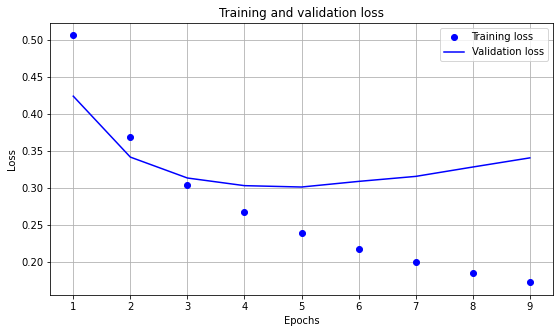

In [28]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

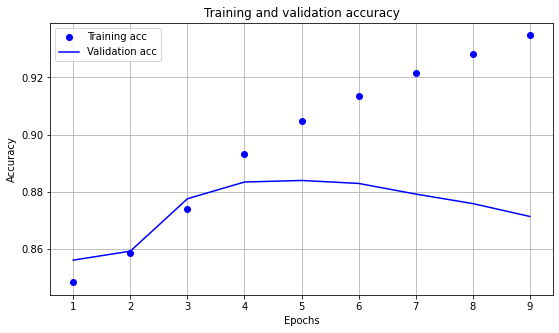

In [29]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [30]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Juego de bazas cooperativo. Con una mecánica que puede recordar a los juegos de baraja españoles típicos, como el tute, el arrastrado, guiñote etc ... consigue un puntito diferente al ser cooperativo. Al inicio de cada misión se reparte toda la baraja y se establecen unos criterios a cumplir, normalmente consistirá en que determinadas personas se tienen que llevar una o varias bazas con determinadas cartas, pero puede venir aderezado con un orden absoluto, o relativo entre bazas o varias consideraciones más que van aumentando la dificultad del reto. Entre los jugadores no se pueden dar indicaciones libremente de qué cartas tienen o qué cartas quieren que se jueguen por lo que acaba siendo un puzzle a resolver entre todos bastante entretenido Con la posibilidad jugar a dos (aunque lo suyo es ser más), yo lo juego con mi hijo pequeño de 6 años siendo un reto muy estimulante para el. Es un ejercicio bastante interesante para el ya que le dejo "tomar las decisiones" que llevan a re

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
## APPLY MODEL ON NON-RATED COMMENTS

In [32]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Wingspan is a decent game, nice mechanics, interesting theme and it looks good (I will never forget those colored eggs or the dice tower).  But for me it was just another euro that I played for a couple of times and then it sat on my shelf.  So I have ended up selling it."
score: 0.000000

input:
"players: 1-4 weight: 3.0 time: 60-840  cooperative campaign  Feb. 2021"
score: 1.000000

input:
"too expensive price in south korea."
score: 0.000000

input:
"A co-op game that was sold at Kickstarter only."
score: 0.000000

input:
"Sundrop Edition, with Artbook and Untold Stories # 2."
score: 1.000000

input:
"With Branch&Claw, Jagged Earth, and 1st & 2nd promo spirits "
score: 1.000000

input:
"This is Terra Mystica sequal in space - Very EuroGame"
score: 1.000000

input:
"Also: Spirit Island: Branch & Claw (2017) exp."
score: 1.000000

input:
"everdell complete collection"
score: 1.000000

input:
"Gorgeous production - looking forward to playing it!"
score: 1.000000


## REGRESSOR

In [33]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002B19C5949D0>,
             param_grid={})

In [34]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [35]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [36]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [37]:
epochs = range(1, len(mean_squared_error) + 1) 

In [38]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.46


In [39]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.02


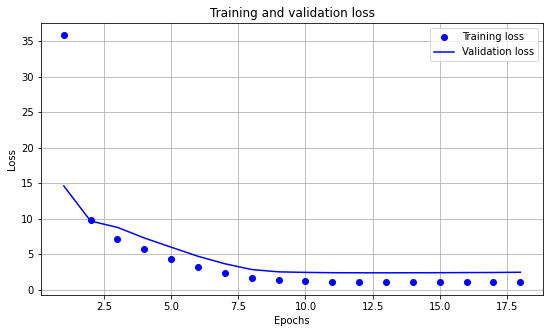

In [40]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

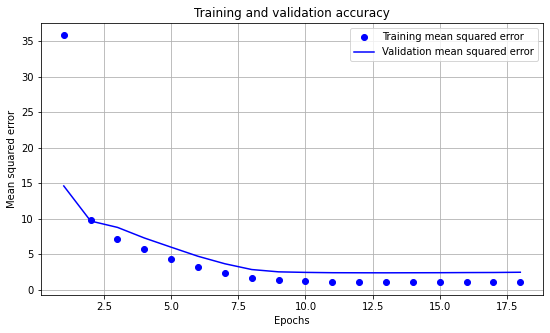

In [41]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [42]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Juego de bazas cooperativo. Con una mecánica que puede recordar a los juegos de baraja españoles típicos, como el tute, el arrastrado, guiñote etc ... consigue un puntito diferente al ser cooperativo. Al inicio de cada misión se reparte toda la baraja y se establecen unos criterios a cumplir, normalmente consistirá en que determinadas personas se tienen que llevar una o varias bazas con determinadas cartas, pero puede venir aderezado con un orden absoluto, o relativo entre bazas o varias consideraciones más que van aumentando la dificultad del reto. Entre los jugadores no se pueden dar indicaciones libremente de qué cartas tienen o qué cartas quieren que se jueguen por lo que acaba siendo un puzzle a resolver entre todos bastante entretenido Con la posibilidad jugar a dos (aunque lo suyo es ser más), yo lo juego con mi hijo pequeño de 6 años siendo un reto muy estimulante para el. Es un ejercicio bastante interesante para el ya que le dejo "tomar las decisiones" que llevan a r

## COMPARE CLASSIFIER VS REGRESSOR

In [43]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Area Control / Area Influence Grid Movement Variable Player Powers  W3.36 No.1-5 90-115min"
    reg score: 8.68
    clf score: 1

"Best game I have played, everything I am looking for in a good euro game."
    reg score: 9.16
    clf score: 1

"It's nothing more than Dungeons & Dragons all over again with a makeover for today. Was dragged into playing this mess- painful. PERFECT example of a board game that is better off played on a computer/PC game (Baldur's Gate, or any other RPG). Boring beyond belief and tons of work just to get characters/creatures simply moving around. Playing this is like stepping backwards in time, which I suppose explains it's popularity. Lots of adults getting a chance at revisiting their happy childhood days of D&D. Also, ugly cardboard standees in an era of miniatures... Bah. There are just too many other games to play."
    reg score: 7.64
    clf score: 0

"I really need to try a Vital Lacerda game. They all have such lovely artwork and are deep, meaty g

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [44]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.19 |           3854 |
| 162886 |          8.36 |           3531 |
| 167355 |          8.42 |           1822 |
| 167791 |          8.21 |           8270 |
| 169427 |          8.65 |            234 |


In [45]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [46]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.05 |            255 |
| 162886 |          8.15 |            317 |
| 167355 |          8.31 |            214 |
| 167791 |          8.29 |            439 |
| 169427 |          8.49 |             71 |


In [47]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [48]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/tQVVSXc...","<a href=""https://boardgamegeek.com/boardgame/3...",6.211667,8.655545,7.297835,1,2022
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.819167,7.742085,7.812884,2,2020
2,"<img src=""https://cf.geekdo-images.com/OodUXfX...","<a href=""https://boardgamegeek.com/boardgame/2...",7.500000,7.762750,7.687679,3,NaN
3,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.827914,8.216048,7.962758,4,2021
4,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.101912,7.930989,8.085498,5,2020


In [49]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [50]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Witcher: Old World,6.211667,8.655545,7.297835,1,2022
2,,Lost Ruins of Arnak,7.819167,7.742085,7.812884,2,2020
3,,Arydia: The Paths We Dare Tread,7.500000,7.762750,7.687679,3,NaN
4,,Oath: Chronicles of Empire and Exile,7.827914,8.216048,7.962758,4,2021
5,,Dune: Imperium,8.101912,7.930989,8.085498,5,2020


In [51]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Imperium: Classics,9.083333,6.421703,8.417926,28,2021
2,,Lost Ruins of Arnak: The Search for Professor Kutil,8.888889,8.468787,8.812507,19,2021
3,,Eclipse: Second Dawn for the Galaxy,8.722904,8.016900,8.614084,41,2020
4,,Brass: Birmingham,8.681239,8.286737,8.645699,23,2018
5,,Middara: Unintentional Malum – Act 1,8.647992,8.488753,8.610924,42,2019


In [52]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Lost Ruins of Arnak: The Search for Professor Kutil,8.888889,8.468787,8.812507,19,2021
2,,Brass: Birmingham,8.681239,8.286737,8.645699,23,2018
3,,Eclipse: Second Dawn for the Galaxy,8.722904,8.016900,8.614084,41,2020
4,,Middara: Unintentional Malum – Act 1,8.647992,8.488753,8.610924,42,2019
5,,Gloomhaven: Jaws of the Lion,8.595662,8.143885,8.550912,22,2020


In [53]:
# model.save('saved_model\my_model')

In [54]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [55]:
# some examples on "long" comments vs short comments

In [56]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [57]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Probado con Automa, es un juego de combos entretenido y ni mucho menos tan sencillo como parece. No me gusta el tema, ni la iconografía, ni los cubitos. Veremos a más jugadores..."
score: 5.00

"This is the worst hype of all time boardgame industry, even more so when digitized by Asmodee, no flame, bare truth."
score: 5.07

"Includes: Countless Terror 1-4 player game mat, cards sleeved and coin protectors on tokens. Played 3 times."
score: 5.84

"2 players  I played a partial game with Suzy but she disliked it so much that we stopped.  I would like to give it more of a try but Suzy is not interested."
score: 6.15

"The transformation from a rectangular field to a flat circle made the appearance very pleasant. But its size takes up a lot of space."
score: 6.99

"Distilled version of 7 Wonders in a 2-player package.  I like this quite a bit.  I think this checks the boxes I care about for a "quick" two player strategic experience."
score: 7.27

"Best 3-4 players? Limited replayability? 